# Predictive Model For Customer Retention of DKB

<br>
<br>

Customers are that machine which produces profit for a business in a indirect way. Therefore the knowledge about the future retention of a customer is arguably one of the most valuable information in business organizations. The
objective of this report is to develop a model using machine learning methods, which can predict the likelihood of customer retention with high precision. For this special task, we are given data on 10000 customers of DKB. From these given examples we want to extract the valuable information about the retention of future customers. It is also required to identify the customers who are less likely to be retained. For these customers we probabely need some kind of marketing actions so that they won't leave the company. The whole analysis has been done in **Python** and consists mainly of four parts:






- **Explorative analysis** 
- **Model tuning, selection and evaluation**
- **Conclusion**


### 1. Explorative analysis
In this part of the challenge, some common features of the provided
data will be summarized by e.g. some measures of location, dispersion measures and visualizations. Before starting to build a model, it is often helpful to get some knowledge about the given data.

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
import scipy.sparse as sparse

In [100]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (2).csv


In [132]:
dataRaw = pd.read_csv("data.csv")
dataRaw.columns

Index(['id', 'last_name', 'credit_score', 'country', 'gender', 'age',
       'years_customer', 'balance_euros', 'num_products', 'has_credit_card',
       'is_active', 'salary_euros', 'retained'],
      dtype='object')

In the first step, the requiered packages and the known dataset are uploded. This dataset consists of 10000 observations and 13 variables. Since the variables **id** and **last_name** obviously do not have any influence on customer retention, we remove them. Most of the features are quantitative and
some of them are qualitative. The target variable is binary and takes on values 0 and 1(1 := yes  and 0 := no). 



In [0]:
Data_pred = dataRaw.copy()
dataRaw = dataRaw.drop(columns= ["id", "last_name"])

In [10]:
print("unique values of target variable:", dataRaw.retained.unique(), "\n")
print("Type of the variables: \n \n",dataRaw.dtypes, "\n")

unique values of target variable: [0 1] 

Type of the variables: 
 
 credit_score         int64
country             object
gender              object
age                  int64
years_customer       int64
balance_euros      float64
num_products         int64
has_credit_card      int64
is_active            int64
salary_euros       float64
retained             int64
dtype: object 



The following table summarizes all quantitative variables in the dataset by using some common distributional parameters(mean, standard deviation, quantiles and so on). It shows that, mean of the target variable(retained) is 0.8, i.e. 80% of the customers has been retained. It follows that there is a class imbalance in our dataset. Customers are in average 39 years old. 71% of them are credit card holder. They earn in average about 100000 euros.


In [11]:
dataRaw.describe().round(2)

,credit_score,age,years_customer,balance_euros,num_products,has_credit_card,is_active,salary_euros,retained
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.8
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,1.0
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,1.0
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,1.0
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


The following figure shows the density and boxplot of each quantitative variable. As we can see that the distribution of variables credit score and salary are independent of customer retention. For all other variables we can observe some dependencies. Specially the variable age is strongly dependent on retention. The likelihood, that a retained customer is younger than a non retained customer is almost always higher. 


In [0]:
dataRaw['retained'] = dataRaw['retained'].apply(lambda x: 'yes' if x == 1 else 'no')

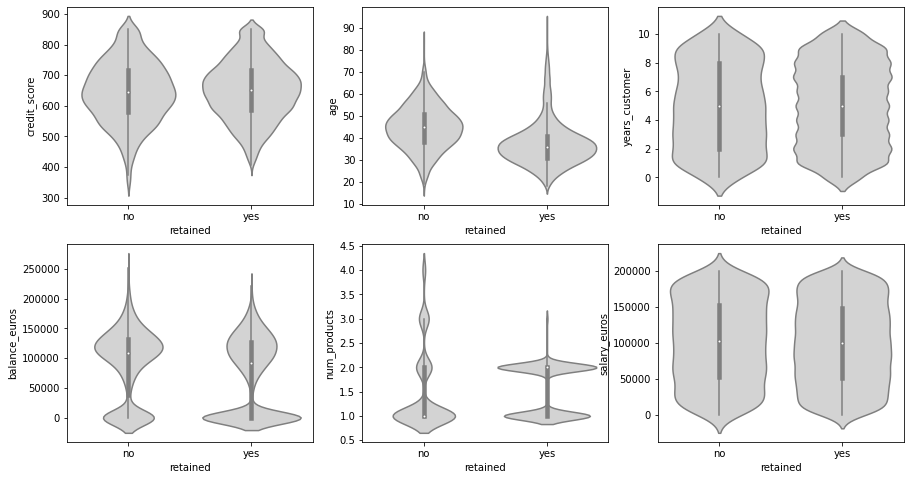

In [13]:
quant_columns = ["credit_score", "age", "years_customer", 
              "balance_euros", "num_products", "salary_euros"]
data_quant = dataRaw[quant_columns]
n = len(quant_columns)
plt.figure(figsize=(15, 8))
for i in range(1, n+1):
    plt.subplot(2, 3, i)
    sns.violinplot(x = dataRaw["retained"],  
                  y =  data_quant.iloc[:,i-1], color = "lightgray" )

The following figure shows the number of retention in absolute value for each categorial variable. At first, we consider the variable country. In the top left plot, we can see that swiss customers have surprisingly higher retention rate than the german customers. male and active customers have also higher retention rate than female and inactive customers. In the bottom left plot, we observe once again that we have a imbalanced Dataset.

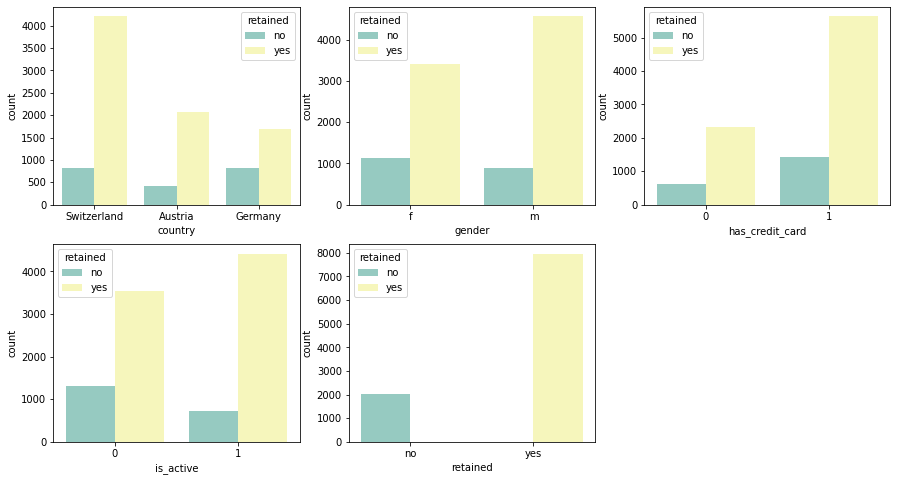

In [14]:
data_categorial = dataRaw.drop(columns = quant_columns)
plt.figure(figsize=(15, 8))
for i in range(1, 6):
    ax = plt.subplot(2, 3, i)
    sns.countplot(ax = ax, x= data_categorial.columns[i-1], data= data_categorial, palette="Set3", hue = 'retained')

The following figure plots correlation matrix of quantitative features. As we can see, the variable **num_product** is negatively correlated with **balance_euros**. Apart from that, all variables are almost uncorrelated. If two variables are highly correlated, then we have redundancy in dataset. Therefore we have to remove one of them. Since in our case the correlation between **num_product** and **balance_euros** is not so high, we will consider both of them for our retention model.

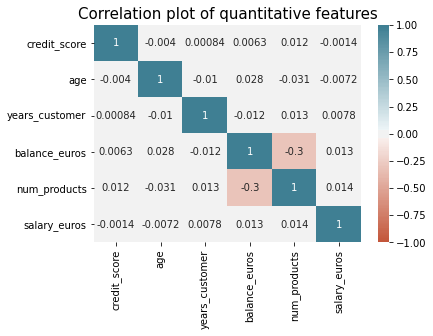

In [15]:
corr = data_quant.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200), annot = True)
ax.set_title("Correlation plot of quantitative features", fontsize = 15)
plt.show()

### 2. Data preperation, model tuning and selection

 Before we start building models, we have to confirm that our data is clean. To get a good predictive model, a properly cleaned dataset is unavoidable. Data cleaning includes, e.g. removing unwanted observations, filtering unwanted outliers, handling missing data and so on. Here we have to verify, if there are any **not available** cases in, if there are too many levels in a categorial variable, if we need a feature transformation or creation and so on. The following table shows that our dataset is complete, i.e. there does not exist any **not available** cases. Levels reduction is also not necessary, since we do not have too many levels for any categorial variable. But the categorial variables have to be transformed into dummy variables, since our selected classifiers can not deal with categorial variables. 
 
 
 Models learned by the algorithm should not only memorize the training examples. They should also perform well on the unseen data. Therefore, it is also necessary to examine how good the generalization performance of a data driven model is (model evaluation). Since in our case unseen data are not available, we devide our complete dataset into training and testset. Our selected learning algorithm are applied on the training data and test data are used for model evaluation.

In [16]:
print("are there any not available cases? \n \n", dataRaw.isna().any(), "\n")
print("Number of levels for each categorial variables: \n \n", data_categorial.apply(lambda x: x.nunique(), axis = 0))
X=dataRaw.drop(columns = "retained")
y=dataRaw.retained
X= pd.get_dummies(X, prefix_sep="_",columns=X.select_dtypes(include=[object]).columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

are there any not available cases? 
 
 credit_score       False
country            False
gender             False
age                False
years_customer     False
balance_euros      False
num_products       False
has_credit_card    False
is_active          False
salary_euros       False
retained           False
dtype: bool 

Number of levels for each categorial variables: 
 
 country            3
gender             2
has_credit_card    2
is_active          2
retained           2
dtype: int64


Since customer retention is a binary target variable, a large number of learning algorithms are applicable on our available dataset. To develop retention models, we use some tree based ensamble approaches, namely gardient boosting and Random Forest. Like other ensemble methods boosting and random forest aggregates many models to get a better prediction and can be applied to many statistical learning methodes (here decision tree). A very special characteristics of boosting is that the models do not depend on boostrap resampling. In this approach every sub-model are developed successively
and can be improved using information from previously developed model. This kind of approach tells us that boosting sub-models are not independent. For our given task we use a standard machine learning library for predictive data analysis **scikit-learn**(also known as **sklearn**) and a standard package for gradient boosting **XGboost**. we first create a model as an object and set its parameters and options. For both algorithms (Randomforest and xgboost), we fit 
the model to the actual data using a method of the object. We do not set any parameter and use the default setting of the object. Finally, we make a prediction using some test data. 

In [0]:
# Train/Fit a model
rf = RandomForestClassifier(random_state=5, verbose=0)
xgb = XGBClassifier(random_state = 6, verbosity = 0)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
#predict class probability
pred_rf_prob = rf.predict_proba(X_test)
pred_xgb_prob = xgb.predict_proba(X_test)
#hard classification
pred_rf = rf.predict(X_test)
pred_xgb = xgb.predict(X_test)

After training the model, now we come to the very important part of our task, namely model assessment. Using some performance measures, we try to find out, how well our trained model generalizes and which model (RF-Model or xgb-model) has a better generalization performance. Finding an approperiate performance measure is a big challenge. In practice, the aria under the curve (AUC) is a often used performance measure for binary classification. A ROC curve plots TPR vs. FPR at different classification thresholds (in our case thresholds = 0.5). AUC is simply the aria under this curve. The larger the AUC, the better the generalization performance is. Below, we have listed values of some performance measures. But we specially focus on AUC.

In [56]:
# Calculate performance measures for random forest
print("performance measures for random forest:\n")
cnf_matrix = metrics.confusion_matrix(y_test, pred_rf)
print("Confusion Matrix: \n", cnf_matrix)

print('Classification Accuracy: ',   metrics.accuracy_score(y_test, pred_rf))
print('Classification Error: \t',    1 - metrics.accuracy_score(y_test, pred_rf))
print("Recall:  \t\t",               metrics.recall_score(y_test, pred_rf, pos_label= 'yes'))
print("Precision: \t\t",             metrics.precision_score(y_test, pred_rf, pos_label='yes'))
print("F1 score: \t\t",              metrics.f1_score(y_test, pred_rf, pos_label= 'yes'))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, pred_rf_prob[:,1]), "\n\n")

# Calculate performance measures for xgboost
print("performance measures for XGBoost:\n")
cnf_matrix = metrics.confusion_matrix(y_test, pred_xgb)
print("Confusion Matrix: \n", cnf_matrix)

print('Classification Accuracy: ',   metrics.accuracy_score(y_test, pred_xgb))
print('Classification Error: \t',    1 - metrics.accuracy_score(y_test, pred_xgb))
print("Recall:  \t\t",               metrics.recall_score(y_test, pred_xgb, pos_label= 'yes'))
print("Precision: \t\t",             metrics.precision_score(y_test, pred_xgb, pos_label='yes'))
print("F1 score: \t\t",              metrics.f1_score(y_test, pred_xgb, pos_label= 'yes'))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, pred_xgb_prob[:,1]))

performance measures for random forest:

Confusion Matrix: 
 [[ 240  261]
 [  87 1912]]
Classification Accuracy:  0.8608
Classification Error: 	 0.1392
Recall:  		 0.9564782391195598
Precision: 		 0.8798895536125173
F1 score: 		 0.9165867689357623
AUC: 			 0.8438470732372173 


performance measures for XGboost:

Confusion Matrix: 
 [[ 235  266]
 [  76 1923]]
Classification Accuracy:  0.8632
Classification Error: 	 0.13680000000000003
Recall:  		 0.9619809904952477
Precision: 		 0.8784833257195066
F1 score: 		 0.9183381088825214
AUC: 			 0.8574791387709823


As we can see in the table above, the both learning algorithms have a high generalization performance. Both algorithm have an AUC higher than 80%. The classification accuracy in both cases is also very high. Below, we have plotted the ROC curve to make a comparison between RF-Model and xgb-Model. It shows that Random forest outperforms XGboost.

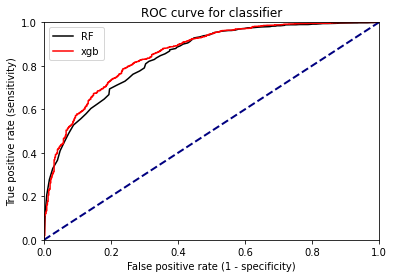

In [50]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, pred_rf_prob[:,1], pos_label = 'yes')
fpr_xgb, tpr_xgb, thresholds = metrics.roc_curve(y_test, pred_xgb_prob[:,1], pos_label = 'yes')
fig, ax = plt.subplots()
ax.plot(fpr_rf, tpr_rf, color = 'black', label = 'RF')
ax.plot(fpr_xgb, tpr_xgb, color = 'red', label = "xgb")
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for classifier')
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
ax.legend()
plt.show()

As we have already observed that learning algorithms are characterized by some parameters. Different sets of parameters do not necessarily lead to the same generalization performance. So the idea is finding a parameter set, for which the model has the best generalization performance. This is called model selection. But in practice, it is infeasible to run the algorithm for every combination of paratemers. We can make it feasible by choosing a small subset of parameters space. We fit the model every time on this small subset of parameters and choose that model which has the best generalization performance. This way of finding optimal parameter set is known as **grid search**. In the following, we shortly describe the parameters, for which we are going to run a grid

Since the task is not to find the best model, we run a grid search with small and unrealistic numbers of parameter values, so that we do not have to spend a lot time in parameter tuning.





In [0]:
param_RF =  {'n_estimators': [10, 20, 30], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'], # More detailed than caret
              'max_depth': [5, 10], 
              'min_samples_split': [4],
              'min_samples_leaf': [10]
             }

param_xgb = {'max_depth': [2,4,6],
             'learning_rate': [0.01, 0.02, 0.04, 0.05],
             'booster': ['gbtree'],
             'gamma': [0],
             'colsample_bytree': [1],
             'min_child_weight': [1],
             'subsample': [1]
        }

np.random.seed(10)
grid_rf = GridSearchCV(rf, param_RF, cv = 5, scoring = 'roc_auc')
grid_rf.fit(X_train, y_train)

np.random.seed(11)
grid_xgb = GridSearchCV(xgb, param_xgb, cv = 5, verbose= 0, scoring = 'roc_auc')
grid_xgb.fit(X_train, y_train)


In [251]:
print("Random Forest: \n")
print("Best AUC from grid search: ", grid_rf.best_score_)
print("Best parameter set from grid search: ", grid_rf.best_params_, "\n")

print("XGBoost: \n")
print("Best AUC from grid search: ", grid_xgb.best_score_)
print("Best parameter set from grid search: ", grid_xgb.best_params_)

rf_bstmod = grid_rf.best_estimator_
xgb_bstmod = grid_xgb.best_estimator_

Random Forest: 

Best AUC from grid search:  0.8583964463365559
Best parameter set from grid search:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 30} 

XGBoost: 

Best AUC from grid search:  0.8654396333873263
Best parameter set from grid search:  {'booster': 'gbtree', 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1}


In [0]:
rf_bstmod.fit(X_train, y_train)
xgb_bstmod.fit(X_train, y_train)

In [0]:
y_pred_best_rf = rf_bstmod.predict(X_test)
y_pred_best_prob_rf = rf_bstmod.predict_proba(X_test)[:,1]

y_pred_best_xgb = xgb_bstmod.predict(X_test)
y_pred_best_prob_xgb = xgb_bstmod.predict_proba(X_test)[:,1]

In [75]:
# Calculate performance measures for random forest
print("performance measures for random forest:\n")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_best_rf)
print("Confusion Matrix: \n", cnf_matrix)

print('Classification Accuracy: ',   metrics.accuracy_score(y_test, y_pred_best_rf))
print('Classification Error: \t',    1 - metrics.accuracy_score(y_test, y_pred_best_rf))
print("Recall:  \t\t",               metrics.recall_score(y_test, y_pred_best_rf, pos_label= 'yes'))
print("Precision: \t\t",             metrics.precision_score(y_test, y_pred_best_rf, pos_label='yes'))
print("F1 score: \t\t",              metrics.f1_score(y_test, y_pred_best_rf, pos_label= 'yes'))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, y_pred_best_prob_rf), "\n\n")

# Calculate performance measures for xgboost
print("performance measures for XGBoost:\n")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_best_xgb)
print("Confusion Matrix: \n", cnf_matrix)

print('Classification Accuracy: ',   metrics.accuracy_score(y_test, y_pred_best_xgb))
print('Classification Error: \t',    1 - metrics.accuracy_score(y_test, y_pred_best_xgb))
print("Recall:  \t\t",               metrics.recall_score(y_test, y_pred_best_xgb, pos_label= 'yes'))
print("Precision: \t\t",             metrics.precision_score(y_test, y_pred_best_xgb, pos_label='yes'))
print("F1 score: \t\t",              metrics.f1_score(y_test, y_pred_best_xgb, pos_label= 'yes'))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, y_pred_best_prob_xgb))

performance measures for random forest:

Confusion Matrix: 
 [[ 206  295]
 [  63 1936]]
Classification Accuracy:  0.8568
Classification Error: 	 0.1432
Recall:  		 0.9684842421210605
Precision: 		 0.8677722994173016
F1 score: 		 0.9153664302600472
AUC: 			 0.8570118392529599 


performance measures for XGBoost:

Confusion Matrix: 
 [[ 229  272]
 [  73 1926]]
Classification Accuracy:  0.862
Classification Error: 	 0.138
Recall:  		 0.9634817408704353
Precision: 		 0.8762511373976342
F1 score: 		 0.9177984274481772
AUC: 			 0.8600128407517131


From the figure below, it is difficult to find out which algorithm provides a better result. But in the table above, one can observe that parameter tuning gives a slight improvement in generalization preformance: 

- **AUC of RF before parameter tuning:**  0.8438
- **AUC of xgb before parameter tuning:** 0.8574
- **AUC of RF after parameter tuning:** 0.8570
- **AUC of xgb after parameter tuning:** 0.8600

And again XGBoost outperforms random forest. So our final selected model for customer retention is **xgb after parameter tuning** with parameters below:

In [76]:
print(grid_xgb.best_params_)

{'booster': 'gbtree', 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1}


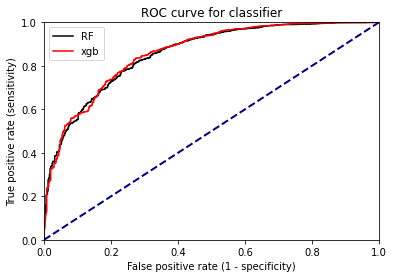

In [125]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, y_pred_best_prob_rf, pos_label = 'yes')
fpr_xgb, tpr_xgb, thresholds = metrics.roc_curve(y_test, y_pred_best_prob_xgb, pos_label = 'yes')
fig, ax = plt.subplots()
ax.plot(fpr_rf, tpr_rf, color = 'black', label = 'RF')
ax.plot(fpr_xgb, tpr_xgb, color = 'red', label = "xgb")
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for classifier')
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
ax.legend()
plt.show()

As we have already mentioned above, it is required to find the top k customers at highest risk of leaving DKB from the customers currently retained. Such customers are listed in the following table with customer id and last name.

In [0]:
Data_pred_1 = Data_pred[Data_pred["retained"] == 1]
X_1 = Data_pred_1.drop(columns = ['id', 'last_name', 'retained'])
X_1 = pd.get_dummies(X_1, prefix_sep="_",columns=X_1.select_dtypes(include=[object]).columns)

In [0]:
Pred_retention = xgb_bstmod.predict_proba(X_1)
#Pred_retention_df = pd.DataFrame(Pred_retention, columns= list(["leaving_prob", "retention_prob" ]))
Data_pred_1["leaving_prob"] = Pred_retention[:,0]
Data_pred_1["retention_prob"] = Pred_retention[:,1]

In [250]:
Data_final = Data_pred_1[["id", "last_name","leaving_prob"]]
Data_final_sort = Data_final.sort_values(by = ["leaving_prob"], ascending=False)
heighstProbLeaving = lambda k: Data_final_sort.iloc[0:k,:]
heighstProbLeaving(k = 5)

,id,last_name,leaving_prob
313,15797960,Skinner,0.929069
8553,15791321,Nwora,0.920006
4174,15810593,Forbes,0.908710
5132,15579826,Young,0.892561
4523,15734202,Chidimma,0.890719


### 3. Conclusion

As already described, the objective of this report was to develop a customer retention model, which can classify the future customers with high accuracy. There are also some machine learning methods, e.g. logistic regression, support vector machine or deep learning, which are also very pupular and useful for modeling some binary target variables, like customer retention. But deep learning might not be a good choice, since we have a very small dataset. For our special task, We have chosen gradient boosting and random forest algorithms. Both algorithm make a single prediction by aggregating many base lerners. As we have seen, for our model setting, gradient boosting outperforms random forest. But it has to be mentioned that the solution we found is not a global solution. Random forest might performs better if we consider another subset of parameter for grid search. We have also observed that our dataset is imbalanced. A model trained by imbalanced dataset might have a good prediction accuracy. But often those models do not work well in practice. A possible solution of this type of problem can be using some methods like down-sampling or over-sampling. Problem can also arise if the cost of misclassification is not always equal for both classes. In this situation, the cost sensitive learning can further improve our model.